In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '/content/drive/My Drive/datasets/monthly_milk_production.csv'

df = pd.read_csv(file_path,index_col="Date" , parse_dates=True)
df.index.freq='MS'

In [21]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

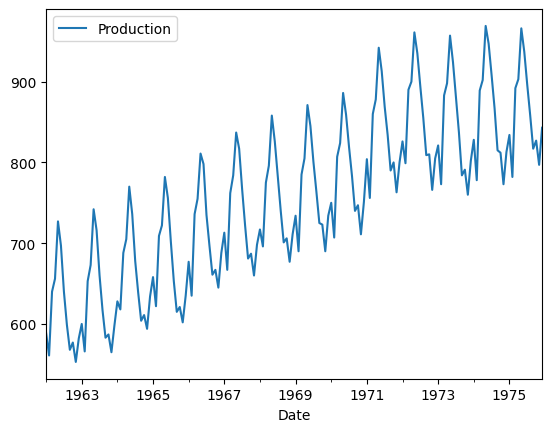

In [22]:
df.plot()

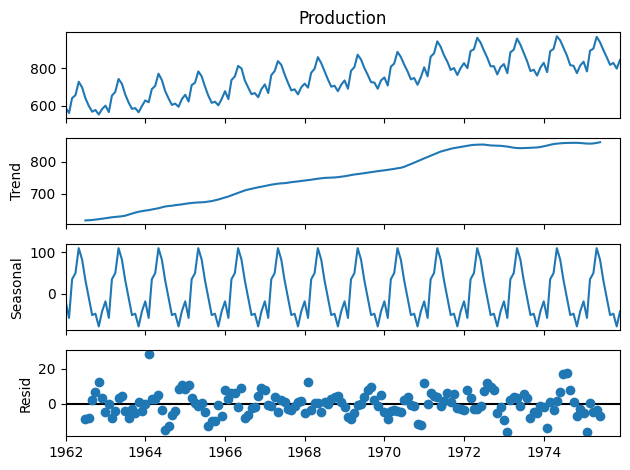

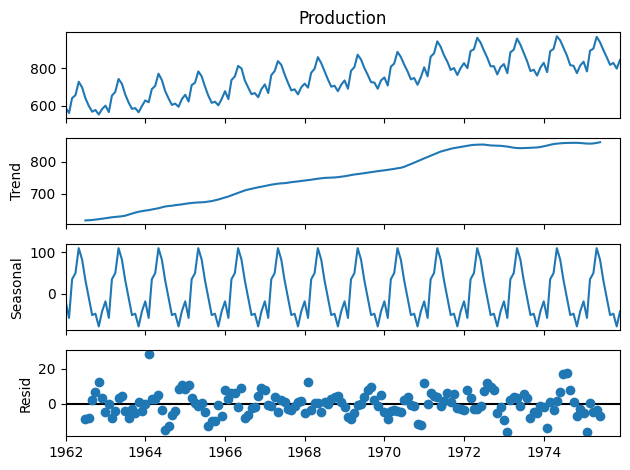

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

period =12
results = seasonal_decompose(df["Production"] , period = period)
results.plot()

In [24]:
len(df)

168

In [25]:
train = df.iloc[:156]
test = df.iloc[156:]

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [33]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [38]:
scaled_train[0:5]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923]])

In [78]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features =1
generator = TimeseriesGenerator(scaled_train , scaled_train , length = n_input , batch_size=1)

In [79]:
x,y = generator[0]

print("given array : ",x.flatten())
print("predicted value : " , y)

given array :  [0.08653846 0.01923077 0.20913462 0.24759615 0.41826923 0.34615385
 0.20913462 0.11057692 0.03605769 0.05769231 0.         0.06971154]
predicted value :  [[0.11298077]]


In [80]:
x.shape


(1, 12, 1)

In [81]:
y.shape

(1, 1)

In [82]:
from keras.models import Sequential
from keras.layers import Dense , LSTM

In [83]:
model = Sequential()
model.add(LSTM(100 , activation="relu" , input_shape=(n_input , n_features)))
model.add(Dense(1))
model.compile(optimizer="adam" , loss="mse")

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
model.fit(generator , epochs=20)

Epoch 1/20
144/144 [==============================] - 4s 16ms/step - loss: 0.0362
Epoch 2/20
144/144 [==============================] - 2s 11ms/step - loss: 0.0238
Epoch 3/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0141
Epoch 4/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0088
Epoch 5/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0081
Epoch 6/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0044
Epoch 7/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 8/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 9/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0035
Epoch 10/20
144/144 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 11/20
144/144 [==============================] - 2s 15ms/step - loss: 0.0036
Epoch 12/20
144/144 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 13/20
144/144 [=

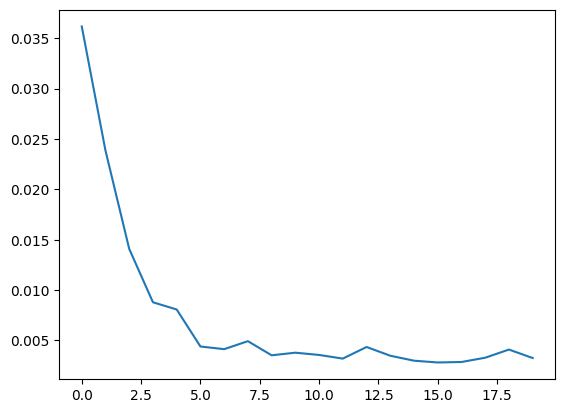

In [86]:
loss = model.history.history["loss"]
plt.plot(range(len(loss)) , loss)

In [87]:
train_batch = scaled_train[-12:]

In [88]:
train_batch = train_batch.reshape(1,n_input, n_features)

In [89]:
model.predict(train_batch)

1/1 [==============================] - 0s 165ms/step


array([[0.62520266]], dtype=float32)

In [90]:
scaled_test[0]

array([0.67548077])

In [101]:
test_pred = []

first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape(1,n_input , n_features)

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_pred.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:] ,[[current_pred]] , axis=1)

1/1 [==============================] - 0s 22ms/step


In [100]:
current_batch.shape

(1, 12, 1)

In [99]:
current_pred.shape

(1,)

In [102]:
test_pred

[array([0.62520266], dtype=float32),
 array([0.6359503], dtype=float32),
 array([0.8029167], dtype=float32),
 array([0.89255136], dtype=float32),
 array([0.99913585], dtype=float32),
 array([0.9885294], dtype=float32),
 array([0.92031074], dtype=float32),
 array([0.805751], dtype=float32),
 array([0.68926764], dtype=float32),
 array([0.62991697], dtype=float32),
 array([0.59209186], dtype=float32),
 array([0.61157304], dtype=float32)]

In [104]:
true_pred = scaler.inverse_transform(test_pred)

<ipython-input-108-ce5517690b0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"]=true_pred


<Axes: xlabel='Date'>

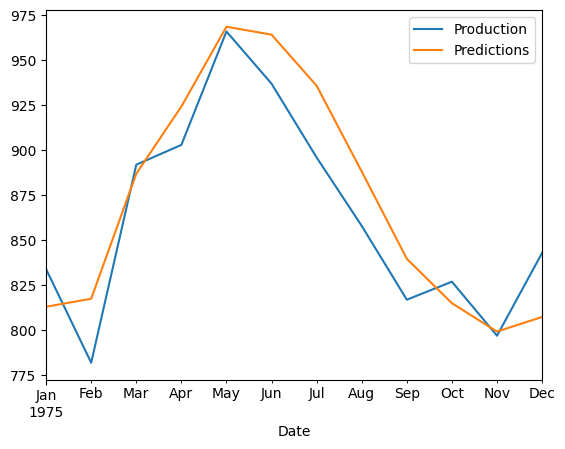

In [108]:
test["Predictions"]=true_pred

test.plot()

In [109]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

24.764958343502446
